In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import tensorflow as tf


from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D

from tensorflow.keras.applications import  VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model




# Prepare the data

In [3]:
train_csv = pd.read_csv("Training_set.csv")
test_csv = pd.read_csv("Testing_set.csv")

train_dir = 'train/'
test_dir = 'test/'

In [4]:
#train_datagen is for training image augmentations

train_datagen = ImageDataGenerator(rescale= 1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,zoom_range=0.2,
                                   horizontal_flip=True,fill_mode='nearest',validation_split=0.2)

#test_datagen is for testing image augmentations
test_datagen = ImageDataGenerator(rescale=1./255)
    

In [5]:
train_data = train_datagen.flow_from_dataframe(dataframe=train_csv,directory=train_dir,
                                               x_col='filename',y_col='label',
                                               target_size=(224,224),batch_size=32,class_mode='categorical',subset='training')

val_data = train_datagen.flow_from_dataframe(dataframe=train_csv,directory=train_dir,
                                               x_col='filename',y_col='label',
                                               target_size=(224,224),batch_size=32,class_mode='categorical',subset='validation')


test_data = test_datagen.flow_from_dataframe(dataframe=test_csv,directory=test_dir,
                                             x_col='filename',
                                             target_size= (224,224),batch_size=32,class_mode=None)

Found 5200 validated image filenames belonging to 75 classes.
Found 1299 validated image filenames belonging to 75 classes.
Found 2786 validated image filenames.


# Creating a Model  : Simply adding a dense softmax layer on top of vgg

In [5]:
vgg = VGG16(input_shape=(224,244,3),weights='imagenet',include_top=False)


#disable training for vgg16 layers
for layer in vgg.layers:
    layer.trainable =False

x = Flatten()(vgg.output)
predictions = Dense(units=75,activation='softmax')(x)





In [7]:
model = Model(inputs=vgg.input,outputs=predictions)

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 244, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 244, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 244, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 122, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 122, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 122, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 61, 128)       0     

In [12]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fit the model

In [35]:
model.fit_generator(train_data,validation_data=val_data,epochs=15,steps_per_epoch=len(train_data),validation_steps=len(val_data))

C:\Users\thakk\AppData\Local\Temp\ipykernel_20040\3180730334.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_data,validation_data=val_data,epochs=15,steps_per_epoch=len(train_data),validation_steps=len(val_data))


Epoch 1/15
163/163 [==============================] - 286s 2s/step - loss: 3.1394 - accuracy: 0.3652 - val_loss: 2.0562 - val_accuracy: 0.5651
Epoch 2/15
163/163 [==============================] - 251s 2s/step - loss: 1.5158 - accuracy: 0.6294 - val_loss: 1.7935 - val_accuracy: 0.5704
Epoch 3/15
163/163 [==============================] - 251s 2s/step - loss: 1.3068 - accuracy: 0.6790 - val_loss: 1.5372 - val_accuracy: 0.6490
Epoch 4/15
163/163 [==============================] - 252s 2s/step - loss: 1.2232 - accuracy: 0.7144 - val_loss: 1.5702 - val_accuracy: 0.6574
Epoch 5/15
163/163 [==============================] - 244s 1s/step - loss: 0.9859 - accuracy: 0.7498 - val_loss: 1.4780 - val_accuracy: 0.6982
Epoch 6/15
163/163 [==============================] - 252s 2s/step - loss: 1.1245 - accuracy: 0.7496 - val_loss: 1.4873 - val_accuracy: 0.6851
Epoch 7/15
163/163 [==============================] - 252s 2s/step - loss: 0.9920 - accuracy: 0.7721 - val_loss: 2.0980 - val_accuracy: 0.6467

In [36]:
model.save('butterfly_classification_model.h5')

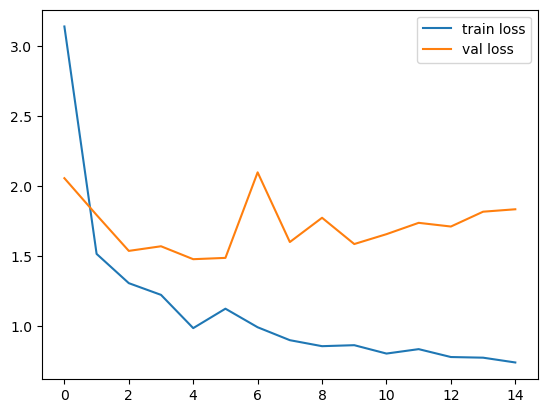

<Figure size 640x480 with 0 Axes>

In [39]:
# loss
plt.plot(model.history.history['loss'], label='train loss')
plt.plot(model.history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

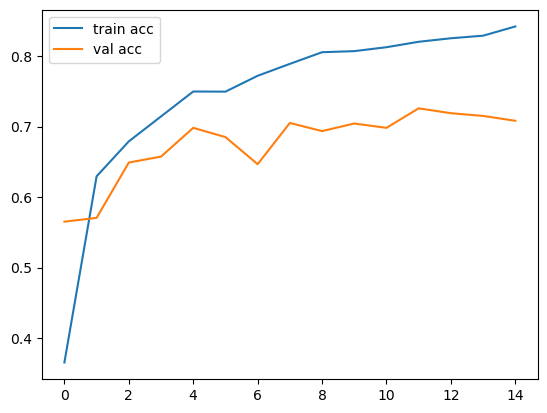

<Figure size 640x480 with 0 Axes>

In [42]:
# accuracies
plt.plot(model.history.history['accuracy'], label='train acc')
plt.plot(model.history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

### The results above tell us that the model is clearly overfitting. The validation loss decreases then fluctuates and the plateaues till last epoch. While the validation accuracy does increase upto some epochs after which it plateaus.

## Loading the model and predicting on test data. No labels are provided for test data so performance was only evaluated using validation split on training data.

In [2]:
loaded_model =load_model("butterfly_classification_model.h5")

In [6]:
predictions = loaded_model.predict(test_data)

88/88 [==============================] - 192s 2s/step


In [8]:
#actual predictions
p = [pred.argmax() for pred in predictions]

In [14]:
class_mappings = train_data.class_indices

In [30]:
prediction_labels = []

for prediction in p:
    for k,v in class_mappings.items():
        if v == prediction:
            prediction_labels.append(k)



In [31]:
prediction_labels

['POPINJAY',
 'AFRICAN GIANT SWALLOWTAIL',
 'ORANGE OAKLEAF',
 'CLOUDED SULPHUR',
 'EASTERN DAPPLE WHITE',
 'PAPER KITE',
 'GREEN CELLED CATTLEHEART',
 'TROPICAL LEAFWING',
 'WOOD SATYR',
 'MOURNING CLOAK',
 'SOOTYWING',
 'AN 88',
 'BLACK HAIRSTREAK',
 'ATALA',
 'APPOLLO',
 'ORANGE TIP',
 'BROWN SIPROETA',
 'APPOLLO',
 'BANDED ORANGE HELICONIAN',
 'GOLD BANDED',
 'ORANGE TIP',
 'PAPER KITE',
 'CLEOPATRA',
 'APPOLLO',
 'RED POSTMAN',
 'BLACK HAIRSTREAK',
 'BANDED PEACOCK',
 'PURPLE HAIRSTREAK',
 'BANDED ORANGE HELICONIAN',
 'VICEROY',
 'VICEROY',
 'PURPLE HAIRSTREAK',
 'SILVER SPOT SKIPPER',
 'RED CRACKER',
 'PINE WHITE',
 'ORCHARD SWALLOW',
 'RED CRACKER',
 'WOOD SATYR',
 'BECKERS WHITE',
 'STRAITED QUEEN',
 'BLUE SPOTTED CROW',
 'GREEN CELLED CATTLEHEART',
 'BLUE SPOTTED CROW',
 'BROWN SIPROETA',
 'QUESTION MARK',
 'CLEOPATRA',
 'MANGROVE SKIPPER',
 'BROWN SIPROETA',
 'BLUE MORPHO',
 'SCARCE SWALLOW',
 'POPINJAY',
 'ADONIS',
 'EASTERN PINE ELFIN',
 'BLUE MORPHO',
 'BLUE MORPHO',
 'PIN